# Trouver le chemin le plus court en maximisant l'emprunt d'aménagements cyclables

### Théorie des graphes - Algortihme Djisktra

A partir des données de routes OpenstreetMap et du schéma cyclable métropolitain de Clermont Auvergne Métropole, on va créer un graphe et résoudre le problème de trouver le chemin le plus court en maximisant les voiries cyclables

librairie Networkx

Librairies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import networkx as nx
# from math import *
from shapely.geometry import LineString, Point, MultiLineString
import warnings
warnings.filterwarnings('ignore')

from pyproj import Proj, transform
inProj = Proj(init='epsg:2154')
outProj = Proj(init='epsg:4326')

Fonction(s)

In [2]:
# on cherche le noeud du graphe le plus proche du point de départ :
def noeudProche(n, liste_n):
    nA = np.array(list(n.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(liste_n.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    return idx[0]


Fichiers

In [3]:
# routes (avec aménagements)
cyc = gpd.read_file(r'fusions_route_amt_cyc.geojson') 
cyc = cyc.to_crs('epsg:2154')


Tris sur le fichier de routes : on ne garde que les routes cyclables (on enlève escalier, chemin privé, etc)

In [5]:
# listes des types de routes contenus dans le fichier : 
['footway', 'residential', 'secondary', 'cycleway', 'primary',
       'platform', 'service', 'primary_link', 'tertiary', 
       'steps', 'living_street', 'pedestrian', 'path', 'proposed',
       'track']

['footway',
 'residential',
 'secondary',
 'cycleway',
 'primary',
 'platform',
 'service',
 'primary_link',
 'tertiary',
 'steps',
 'living_street',
 'pedestrian',
 'path',
 'proposed',
 'track']

Attributions de poids aux types d'aménagment :  on souhaite au maximum éviter les tronçons sans aménagement

In [46]:
# tri et création d'un geodataframe "gdf"
gdf = cyc[cyc.highway.isin(['residential', 'secondary', 'cycleway', 'primary'
                            ,  'primary_link', 'tertiary', 'unclassified',
       'living_street', 'pedestrian','track'])][['geometry', 'amgt_exi', 'amgt_propo', 'maxspeed']].reset_index(drop=True)
# on rempli les aménagemnt cyclables inexistant par le terme "pas d'aménagement"
gdf.amgt_exi.fillna("Pas d'aménagement", inplace=True)

# ...........  on attribue des poids à chaque type d'aménagement  ...........................................................
# ............. plus le poids est faible, plus il a de chance d'être emprunté 
this_is_as_dict = {
 'Double sens cyclable' : 1,
 "Pas d'aménagement" :   5,
 'Piste cyclable bidirectionnelle' : 0.1,
 'Bande cyclable un côté' : 2,
 'Piste cyclable monodirectionnelle' : 0.1,
 'Aire piétonne' : 1,
 'Zone 30' : 1,
 'Aménagement sur trottoir' : 3,
 'Bandes cyclables' : 3,
 'Partage de voirie' : 10,
 'Voie verte' : 0.1,
 'Chaussée à voie centrale banalisée' : 1,
 'Aménagement mixte' : 3,
 'Zone de rencontre' : 1}
df_poids = pd.DataFrame(this_is_as_dict.items(), columns=['amgt_exi', 'poids'])
#........................On fusionne avec le gdf des routes : 
gdf = gdf.merge(df_poids)


# # on créé des points de départ et d'arrivée : 
dep = gpd.GeoSeries(Point([ 3.0983632418937073, 45.779343058557195])).set_crs('epsg:4326')
dep = dep.to_crs('epsg:2154')
arr = gpd.GeoSeries(Point([ 3.1135159913016763, 45.81354421265834])).set_crs('epsg:4326')
arr = arr.to_crs('epsg:2154')


Graphe

In [47]:
# on transofrme les routes en graphe
g = nx.Graph()

for line, poids in zip(gdf.geometry, gdf.poids):
    for i, j in zip(line.coords[1:], line.coords[:-1]):
        g.add_edge(i, j, weight = poids)
        
# On tranforme les noeuds du graphe en geodataframe
gdf_noeuds = gpd.GeoDataFrame(geometry=gpd.points_from_xy(pd.DataFrame(g.nodes)[0],
                                                         pd.DataFrame(g.nodes)[1]))

Application de l'agorithme dijkstra

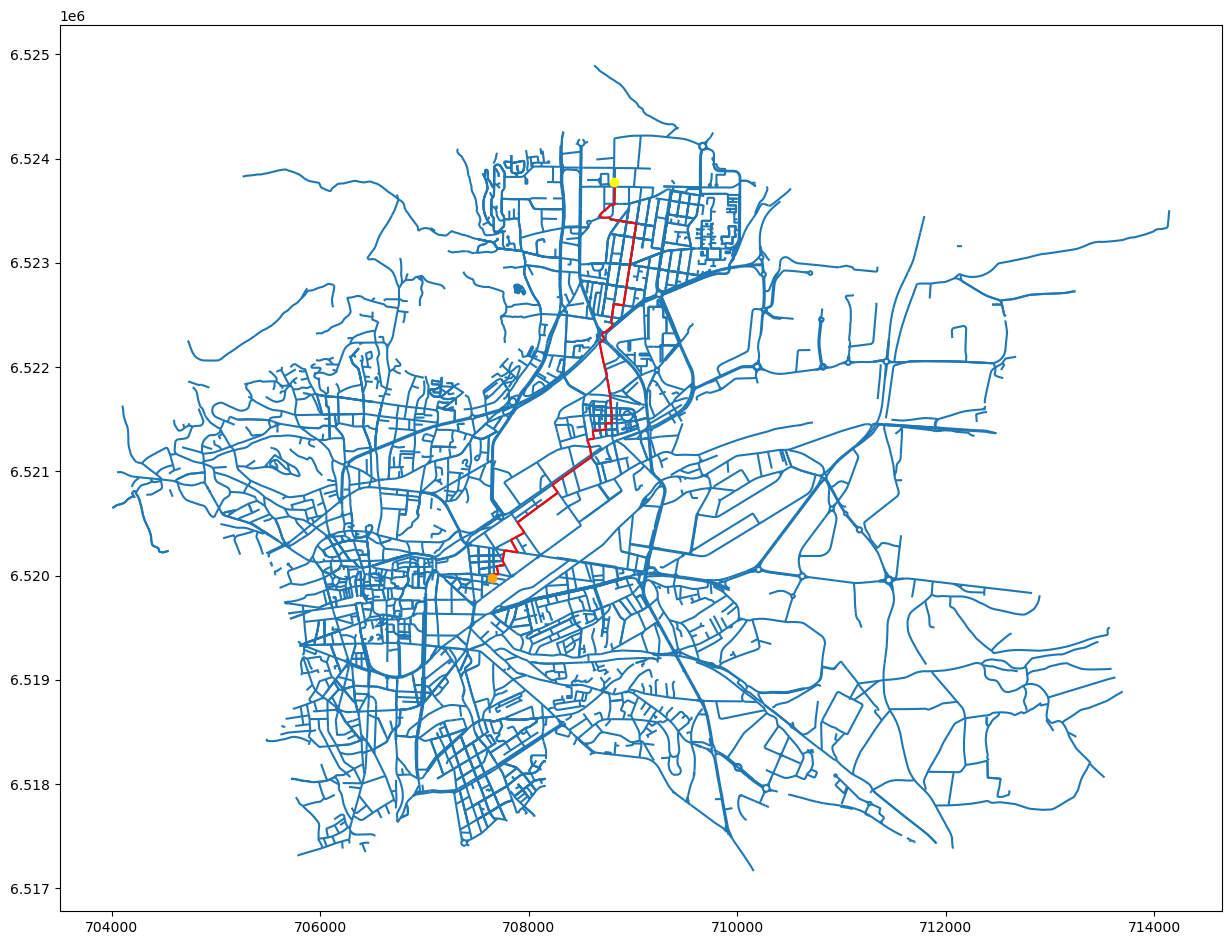

In [48]:
n_dep = noeudProche(dep, gdf_noeuds)

xd = pd.DataFrame(g.nodes)[pd.DataFrame(g.nodes).index==n_dep][0].values[0]
yd = pd.DataFrame(g.nodes)[pd.DataFrame(g.nodes).index==n_dep][1].values[0]


n_arr = noeudProche(arr, gdf_noeuds)
xa = pd.DataFrame(g.nodes)[pd.DataFrame(g.nodes).index==n_arr][0].values[0]
ya = pd.DataFrame(g.nodes)[pd.DataFrame(g.nodes).index==n_arr][1].values[0]

# ALgorithme dijkstra
try:
    chemin = nx.dijkstra_path(g, (xd, yd),
                          (xa, ya),weight='weight')
# chemin

    l_n=list()
    
    # on transforme le chemin issu du graphe en géométrie en lambert 93
    for n1, n2 in zip(chemin[:-1], chemin[1:]):
        l_n.append(LineString([n1,n2]))
    #     l_n.append(noeuds[0], noeuds[1])
    fig, ax = plt.subplots(figsize=(15,35))
    gdf.plot(ax=ax)
    gpd.GeoSeries(l_n).plot(ax=ax, color='red')  
    dep.plot(ax=ax, color='orange', zorder=2)
    arr.plot(ax=ax, color='yellow', zorder=2)
    
except:
    # préciser le type d'exceptions ici. J'ai fait ça pour gagner du temps dans le cas où le poitn de départ se situerait 
    # sur une route non connectée mais c'est pas rigoureux
    print("pas de chemin trouvé")

In [49]:
#on tranforme la géométrie en geoDataFrame
parcours = gpd.GeoDataFrame(geometry=gpd.GeoSeries(l_n))
parcours['length']=parcours.length
#on fait une fusion spatiale avec le fichier "routes"
parcours_merged = parcours.sjoin_nearest(gdf, how='left')#[['amgt_exi','length']]

Traitement : on somme toutes les longueurs du parcours par type de voiries

In [50]:
res = parcours_merged.reset_index().drop_duplicates(['geometry', 'amgt_exi'])#.groupby('amgt_exi').sum()
# res.columns = ['id','amgt_exi', 'length']
# res = res.drop_duplicates(['id', 'length'])
res.amgt_exi = res.amgt_exi.fillna("Pas d'aménagement")
res[['amgt_exi', 'length']].groupby('amgt_exi').sum()
# res

,length
amgt_exi,
Aire piétonne,171.989574
Bande cyclable un côté,86.119428
Bandes cyclables,508.868592
Double sens cyclable,2931.939082
Pas d'aménagement,30.771642
Piste cyclable bidirectionnelle,683.069003
Voie verte,310.919653
Zone 30,3131.447534


Explore avec fond de carte OSM

In [51]:
exp  = parcours_merged.drop_duplicates(['geometry', 'amgt_exi'])#[['amgt_exi', 'length']].groupby('amgt_exi').sum()
exp = exp.set_crs('epsg:2154')
exp = exp.to_crs('epsg:2154')

In [52]:
exp.explore(column='amgt_exi')

Points à améliorer : 

    - ici on considère que les cyclistes peuvent remonter l'ensemble des rues à contre sens pour simplifier la création du graphe. Il serait nécessaire de créer un graphe directionnel
    - passer par des tableaux numpy plutot que des dataframes sur les opérations lourdes
    - le fichier cyc contient une fusion spatiale entre les lignes du shapefile du shéma cyclable et les routes OSM (les lignes du shp du schéma cyc ne coincident pas aux tracés des routes de l'IGN, du coup il faut faire une fusion spatiale "au plus proche", et c'est un peu du bricolage dégueulasse)
    - 1000 autres choses